In [87]:
import pandas as pd
import collections

df = pd.read_csv("../data/experimental/validation.tsv", sep="\t")

df = df[df["Number_of_Protein_Unique_Peptides"] >= 2]
df = df[df["Abundance_Ratio_log2"] > 2.3]
df = df[df["Abundance_Ratio_log2_median_corr"] > 1]
df = df[df["Abundance_Ratio_PValue"] < 0.05]
df = df[df["Abundance_Ratio_Adj_PValue"] < 0.25]
df = df[df["Rank_relative"] < 500]

slcs = []
with open("../data/examples/slc_cemm_interest.txt", "r") as f:
    for l in f:
        slcs += [l.rstrip()]

fid2smi = {}
for r in pd.read_csv("../data/experimental/validation_fid2smi.tsv", sep=",").values:
    fid2smi[r[0]] = r[1]

fid2pid = collections.defaultdict(list)
for r in df[["FragID", "Accession"]].values:
    fid2pid[r[0]] += [r[1]]

In [88]:
R = []
for k,v in fid2pid.items():
    v = set(v)
    s = v.intersection(slcs)
    r = (k, fid2smi[k], len(v), len(s), "; ".join(sorted(s)))
    R += [r]

dr = pd.DataFrame(R, columns=["fid", "smiles", "num_prot", "num_slc", "slc"])
dr.to_csv("../data/experimental/validation_hits_with_slc.tsv", sep="\t", index=False)

# Experimental validation plots

89


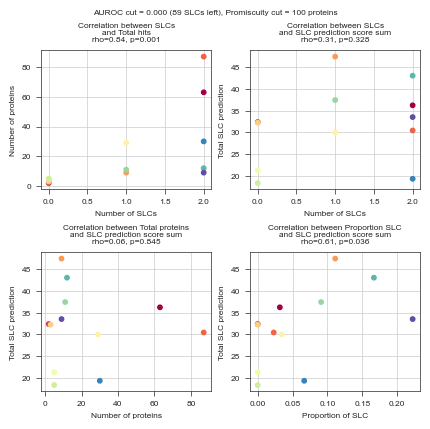

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler as Scaler
import numpy as np
from scipy.stats import pearsonr, spearmanr
import joblib
import stylia

data = pd.read_csv("../results/1_experimental_validation_predictions.tsv", sep="\t")

MIN_AUROC = 0.0
MAX_NUM_PROTEINS = 100

data = data[data["num_prot"] < MAX_NUM_PROTEINS]

protein_precalcs = joblib.load("../data/protein_precalcs.joblib")
protein_aucs = {}
for d in protein_precalcs:
    protein_aucs[d["uniprot_ac"]] = d["auroc"]

slc_columns = []
for slc in list(data.columns)[6:]:
    auroc = protein_aucs[slc][0]
    if auroc is None:
        auroc = 0
    if auroc >= MIN_AUROC:
        slc_columns += [slc]

print(len(slc_columns))

X = np.array(data[slc_columns])
X = Scaler().fit_transform(X)

y_sum = np.sum(X, axis=1)

fig, axs = stylia.create_figure(2, 2, height=stylia.TWO_COLUMNS_WIDTH*0.6, width=stylia.TWO_COLUMNS_WIDTH*0.6)

def correlation_label(x,y):
    rho, pval = spearmanr(x,y)
    return "\nrho={0:.2f}, p={1:.3f}".format(rho, pval)

ax = axs.next()
x = data["num_slc"]
y = data["num_prot"]
ax.scatter(x=x, y=y, c=[i for i in range(len(data))], cmap="Spectral")
stylia.label(ax, title="Correlation between SLCs\nand Total hits"+correlation_label(x,y), xlabel="Number of SLCs", ylabel="Number of proteins")

ax = axs.next()
x = data["num_slc"]
y = y_sum
ax.scatter(x=x, y=y, c=[i for i in range(len(data))], cmap="Spectral")
stylia.label(ax, title="Correlation between SLCs\nand SLC prediction score sum"+correlation_label(x,y), xlabel="Number of SLCs", ylabel="Total SLC prediction")

ax = axs.next()
x = data["num_prot"]
y = y_sum
ax.scatter(x=x, y=y, c=[i for i in range(len(data))], cmap="Spectral")
stylia.label(ax, title="Correlation between Total proteins\nand SLC prediction score sum"+correlation_label(x,y), xlabel="Number of proteins", ylabel="Total SLC prediction")

ax = axs.next()
x = data["num_slc"]/data["num_prot"]
y = y_sum
ax.scatter(x=x, y=y, c=[i for i in range(len(data))], cmap="Spectral")
stylia.label(ax, title="Correlation between Proportion SLC\nand SLC prediction score sum"+correlation_label(x,y), xlabel="Proportion of SLC", ylabel="Total SLC prediction")

plt.tight_layout()
plt.suptitle("AUROC cut = {0:.3f} ({1} SLCs left), Promiscuity cut = {2} proteins".format(MIN_AUROC, len(slc_columns), MAX_NUM_PROTEINS))

stylia.save_figure("../assets/1_prospective_validation_{0}_{1}.png".format(MIN_AUROC, MAX_NUM_PROTEINS))
